In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib

In [2]:
df = pd.read_csv("House_Rent_Dataset.csv")
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [4]:
df.isnull().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [5]:
df.describe(include='object').T

,count,unique,top,freq
Posted On,4746,81,2022-07-06,311
Floor,4746,480,1 out of 2,379
Area Type,4746,3,Super Area,2446
Area Locality,4746,2235,Bandra West,37
City,4746,6,Mumbai,972
Furnishing Status,4746,3,Semi-Furnished,2251
Tenant Preferred,4746,3,Bachelors/Family,3444
Point of Contact,4746,3,Contact Owner,3216


In [6]:
#df['Rent'] = boxcox(df['Rent'])[0]
#df['Size'] = boxcox(df['Size'])[0]

df['Rent'] = np.log1p(df['Rent'])
df['Size'] = np.log1p(df['Size'])

In [7]:
# Drop data unnecesaary
df = df.drop(['Area Locality','Posted On','Floor'], axis=1)

In [8]:
df=df[~df['Point of Contact'].str.contains("Contact Builder")]

def one_hot_encode(data, col):
    encode = pd.get_dummies(data[col], drop_first=True)
    data = data.drop(col, axis=1)
    data = data.join(encode)
    return data

In [9]:
columns = ['Area Type', 'City','Furnishing Status','Tenant Preferred','Point of Contact']
for col in columns:
    df = one_hot_encode(df, col)

In [10]:
# Define features (X) and target (y)
X = df.drop(columns=['Rent'], axis=1)
y = df['Rent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
X.head()

,BHK,Size,Bathroom,Carpet Area,Super Area,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Owner
0,2,7.003974,2,0,1,0,0,0,1,0,0,1,1,0,1
1,2,6.685861,1,0,1,0,0,0,1,0,1,0,1,0,1
2,2,6.908755,1,0,1,0,0,0,1,0,1,0,1,0,1
3,2,6.685861,1,0,1,0,0,0,1,0,0,1,1,0,1
4,2,6.746412,1,1,0,0,0,0,1,0,0,1,0,0,1


In [11]:
# Define parameter grids
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize models
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)

# Fit GridSearchCV
grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

# Best parameters and scores
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Best parameters for Decision Tree:", best_params_dt)
print("Best score for Decision Tree:", best_score_dt)
print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)
print("Best parameters for Gradient Boosting:", best_params_gb)
print("Best score for Gradient Boosting:", best_score_gb)

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best score for Decision Tree: 0.7943528162927643
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
Best score for Random Forest: 0.8158848291064744
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Gradient Boosting: 0.8196953316220895


In [13]:
gb = GradientBoostingRegressor(
    n_estimators= 100,
    learning_rate= 0.1,
    max_depth= 3,
    min_samples_leaf= 10,
    min_samples_split= 2,
    random_state=42
)
gb.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_leaf=10, random_state=42)

In [18]:
# Predict
y_pred_gb = gb.predict(X_test)

# Evaluate models
MSE= mean_squared_error(y_test, y_pred_gb)
R2= r2_score(y_test, y_pred_gb)


In [19]:
print("Mean Squared Error Value:", MSE)
print("R2 value:", R2)

Mean Squared Error Value: 0.15466413663093767
R2 value: 0.8287004639180386


In [26]:
# Save the best model
joblib.dump(gb, 'model_GB.pkl')


['model_GB.pkl']

In [13]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))


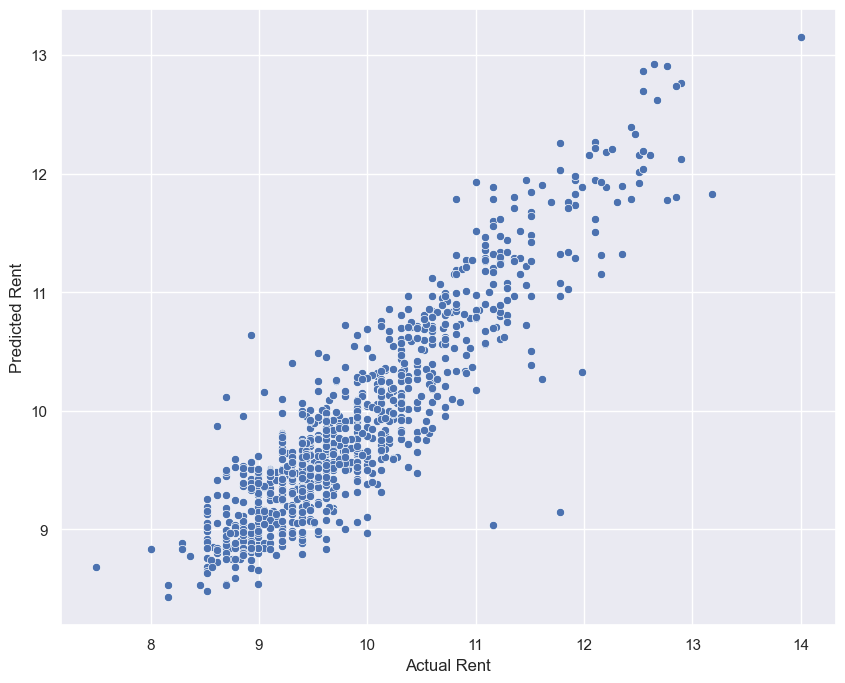

In [25]:
plt.figure(figsize=(10,8))
sns.scatterplot(x= y_test, y=y_pred_gb)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.show()

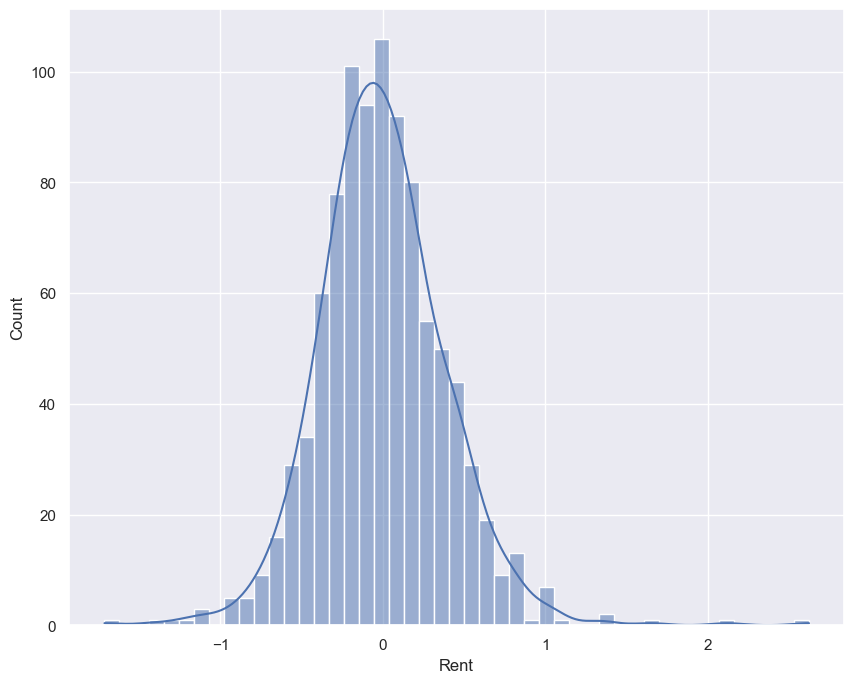

In [24]:
plt.figure(figsize=(10,8))
sns.histplot(y_test - y_pred_gb, kde=True)
plt.show()

Conclusion this model is We achicved R-Squared of 0.81 and the distribution of our residual is also normal.
so our model is doing well in predicted the Rent.